In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
### lists and dicts to help clear dataframes
#list of columns i want to keep
const_cols = ["Province/State", "Country", "Country/Region", "Date last updated", "Last Update", "Confirmed", "Recovered", "Deaths"]
#dict of column names to change
column_names = {"Country": "Country/Region", "Date last updated": "Last Update"}
#dict of columns and values to put in NaNs
fillna_values = {'Province/State': "", "Country/Region": "", "Confirmed": 0, "Recovered": 0, "Deaths":0}

In [3]:
def read_time_series_csv(url, save, file_name):
    
    df_ts = pd.read_csv(url)
    
    #df_ts = df_ts.dropna(axis=0, how='all')
    #df_ts = df_ts.dropna(axis=1, how='all')

    df_text = df_ts[df_ts.columns[0:2]]
    df_text = df_text.fillna(value = '')
    
    df_val = df_ts[df_ts.columns[2:len(df_ts.columns)]]
    df_val = df_val.fillna(value = 0)
    
    df_ts = pd.concat([df_text,df_val],axis=1)
    
    if save == True:
        writer = pd.ExcelWriter(file_name, engine='xlsxwriter')

        df_ts.to_excel(writer, index=False)

        writer.save()

    return df_ts

In [6]:
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/archived_data/time_series/time_series_2019-ncov-Confirmed.csv"
url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/archived_data/time_series/time_series_2019-ncov-Deaths.csv"
url_recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/archived_data/time_series/time_series_2019-ncov-Recovered.csv"

In [7]:
df_confirmed = read_time_series_csv(url_confirmed, True, "COVID19-Confirmed.xlsx")
df_deaths = read_time_series_csv(url_deaths, True, "COVID19-Deaths.xlsx")
df_recovered = read_time_series_csv(url_recovered, True, "COVID19-Recovered.xlsx")

In [8]:
print(df_confirmed)

                  Province/State        Country/Region       Lat       Long  \
0                          Anhui        Mainland China  31.82571  117.22640   
1                        Beijing        Mainland China  40.18238  116.41420   
2                      Chongqing        Mainland China  30.05718  107.87400   
3                         Fujian        Mainland China  26.07783  117.98950   
4                          Gansu        Mainland China  36.06110  103.83430   
5                      Guangdong        Mainland China  23.33841  113.42200   
6                        Guangxi        Mainland China  23.82908  108.78810   
7                        Guizhou        Mainland China  26.81536  106.87480   
8                         Hainan        Mainland China  19.19673  109.74550   
9                          Hebei        Mainland China  38.04280  114.51490   
10                  Heilongjiang        Mainland China  47.86200  127.76220   
11                         Henan        Mainland Chi

In [10]:
print("Shape of df_confirmed: {}".format(df_confirmed.shape))
print("Shape of df_deaths: {}".format(df_deaths.shape))
print("Shape of df_recovered: {}".format(df_recovered.shape))

#printing whole df
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(df_confirmed)

Shape of df_confirmed: (74, 49)
Shape of df_deaths: (74, 49)
Shape of df_recovered: (74, 49)


In [13]:
china_confirmed = df_confirmed[df_confirmed['Country/Region']=="Mainland China"].iloc[:,5:].sum(axis=0)
china_deaths = df_deaths[df_deaths['Country/Region']=="Mainland China"].iloc[:,5:].sum(axis=0)
china_recovered = df_recovered[df_recovered['Country/Region']=="Mainland China"].iloc[:,5:].sum(axis=0)

print(china_confirmed)
#print(china_recovered_series)
#print(china_deaths_series)

1/22/20 12:00      547.0
1/23/20 12:00      639.0
1/24/20 0:00       865.0
1/24/20 12:00      916.0
1/25/20 0:00      1320.0
1/25/20 12:00     1399.0
1/25/20 22:00     1979.0
1/26/20 11:00     2062.0
1/26/20 23:00     2737.0
1/27/20 9:00      2825.0
1/27/20 19:00     2863.0
1/27/20 20:30     4409.0
1/28/20 13:00     4610.0
1/28/20 18:00     5494.0
1/28/20 23:00     5970.0
1/29/20 13:30     6070.0
1/29/20 14:30     6070.0
1/29/20 21:00     7678.0
1/30/20 11:00     8124.0
1/31/20 14:00     9783.0
2/1/20 10:00     11860.0
2/2/20 21:00     17114.0
2/3/20 21:00     20014.0
2/4/20 9:40      20400.0
2/4/20 22:00     24290.0
2/5/20 9:00      24391.0
2/5/20 23:00     28017.0
2/6/20 9:00      28085.0
2/6/20 14:20     28088.0
2/7/20 20:13     31215.0
2/7/20 22:50     34569.0
2/8/20 10:24     34620.0
2/8/20 23:04     37198.0
2/9/20 10:30     37232.0
2/9/20 23:20     40160.0
2/10/20 10:30    40196.0
2/10/20 19:30    42310.0
2/11/20 10:50    42670.0
2/11/20 20:44    44641.0
2/12/20 10:20    44687.0


In [15]:
dates_confirmed = china_confirmed.index.values
dates_deaths = china_deaths.index.values
dates_recovered = china_recovered.index.values

print(dates_confirmed)
#print(dates_1)
#print(dates_2)

dates_datetime_confirmed = pd.to_datetime(dates_confirmed, infer_datetime_format=True)
dates_datetime_deaths = pd.to_datetime(dates_deaths, infer_datetime_format=True)
dates_datetime_recovered = pd.to_datetime(dates_recovered, infer_datetime_format=True)

print(dates_datetime_confirmed)


['1/22/20 12:00' '1/23/20 12:00' '1/24/20 0:00' '1/24/20 12:00'
 '1/25/20 0:00' '1/25/20 12:00' '1/25/20 22:00' '1/26/20 11:00'
 '1/26/20 23:00' '1/27/20 9:00' '1/27/20 19:00' '1/27/20 20:30'
 '1/28/20 13:00' '1/28/20 18:00' '1/28/20 23:00' '1/29/20 13:30'
 '1/29/20 14:30' '1/29/20 21:00' '1/30/20 11:00' '1/31/20 14:00'
 '2/1/20 10:00' '2/2/20 21:00' '2/3/20 21:00' '2/4/20 9:40' '2/4/20 22:00'
 '2/5/20 9:00' '2/5/20 23:00' '2/6/20 9:00' '2/6/20 14:20' '2/7/20 20:13'
 '2/7/20 22:50' '2/8/20 10:24' '2/8/20 23:04' '2/9/20 10:30'
 '2/9/20 23:20' '2/10/20 10:30' '2/10/20 19:30' '2/11/20 10:50'
 '2/11/20 20:44' '2/12/20 10:20' '2/12/20 22:00' '2/13/20 10:00'
 '2/13/20 21:15' '2/14/20 11:23']
DatetimeIndex(['2020-01-22 12:00:00', '2020-01-23 12:00:00',
               '2020-01-24 00:00:00', '2020-01-24 12:00:00',
               '2020-01-25 00:00:00', '2020-01-25 12:00:00',
               '2020-01-25 22:00:00', '2020-01-26 11:00:00',
               '2020-01-26 23:00:00', '2020-01-27 09:00:00',


In [16]:
#something for converting datetime for x axis
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

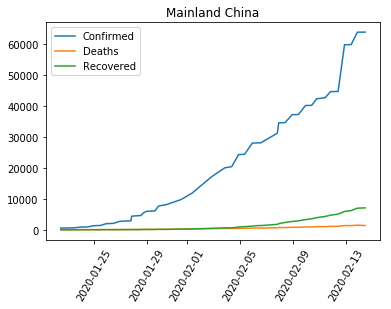

In [18]:
plt.plot(dates_datetime_confirmed, china_confirmed, dates_datetime_deaths, china_deaths, dates_datetime_recovered, china_recovered)
plt.xticks(rotation=60)
plt.legend(['Confirmed', 'Deaths', 'Recovered'])
plt.title("Mainland China")
plt.savefig("img/china.png",bbox_inches='tight')

In [19]:
countries_ts = df_confirmed['Country/Region'].unique()
print(len(countries_ts))
print(countries_ts)

29
['Mainland China' 'Thailand' 'Japan' 'South Korea' 'Taiwan' 'US' 'Macau'
 'Hong Kong' 'Singapore' 'Vietnam' 'France' 'Nepal' 'Malaysia' 'Canada'
 'Australia' 'Cambodia' 'Sri Lanka' 'Germany' 'Finland'
 'United Arab Emirates' 'Philippines' 'India' 'Italy' 'UK' 'Russia'
 'Sweden' 'Spain' 'Belgium' 'Others']


In [24]:
#for country in countries_ts:
    #plt.plot(dates_datetime, ts_df_list[0][ts_df_list[0]['Country/Region']==country].iloc[:,5:].sum(axis=0))
    #plt.show()

In [25]:
#math for using floor
import math

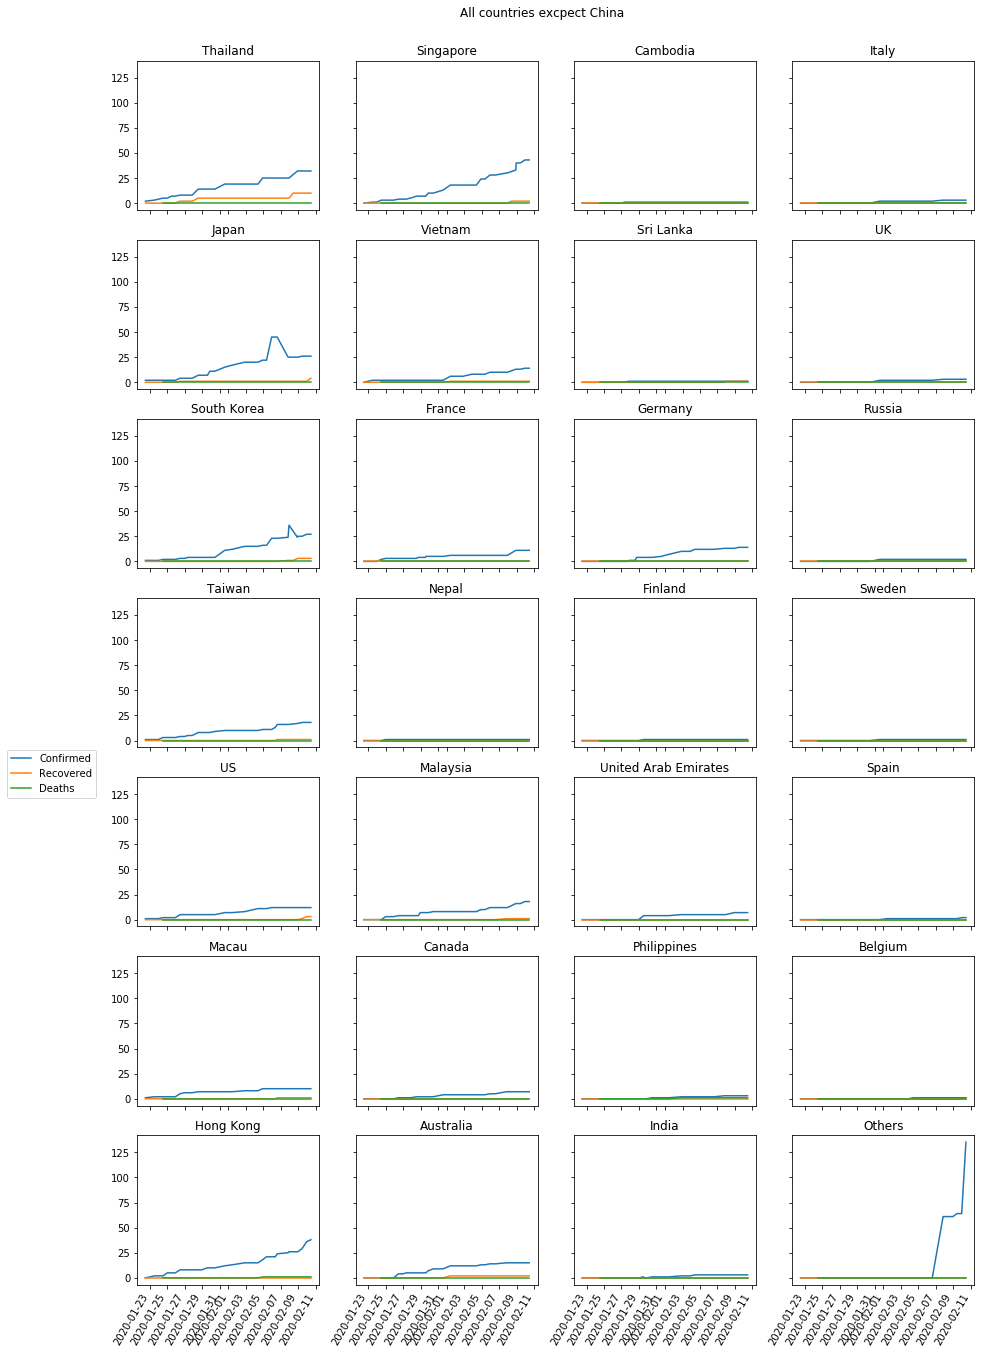

In [32]:
country_confirmed_series = ts_df_list[1][ts_df_list[1]['Country/Region']==countries_ts[0]].iloc[:,5:].sum(axis=0)
country_recovered_series = ts_df_list[2][ts_df_list[2]['Country/Region']==countries_ts[0]].iloc[:,5:].sum(axis=0)
country_deaths_series = ts_df_list[3][ts_df_list[3]['Country/Region']==countries_ts[0]].iloc[:,5:].sum(axis=0)
dates_0 = country_confirmed_series.index.values
dates_datetime_0 = pd.to_datetime(dates_0, infer_datetime_format=True)
dates_1 = country_recovered_series.index.values
dates_datetime_1 = pd.to_datetime(dates_1, infer_datetime_format=True)
dates_2 = country_deaths_series.index.values
dates_datetime_2 = pd.to_datetime(dates_2, infer_datetime_format=True)
    
plots_in_row = 4
#define how many rows on how many countries in list without china
plots_in_col = math.floor((len(countries_ts)-1)/plots_in_row)

fig, axs = plt.subplots(plots_in_col, plots_in_row, figsize=(15, 25), sharey=True, sharex=True)
fig.autofmt_xdate(rotation=60)

axs0 = axs.shape[0]
axs1 = axs.shape[1]

i = 0
j = 0

for country in countries_ts[1:]:
    
    axs[i][j].plot(dates_datetime_0,ts_df_list[1][ts_df_list[1]['Country/Region']==country].iloc[:,5:].sum(axis=0))
    axs[i][j].plot(dates_datetime_1,ts_df_list[2][ts_df_list[2]['Country/Region']==country].iloc[:,5:].sum(axis=0))
    axs[i][j].plot(dates_datetime_2,ts_df_list[3][ts_df_list[3]['Country/Region']==country].iloc[:,5:].sum(axis=0))
    axs[i][j].set_title(country)
    #axs[i][j].set_xticklabels(rotation=90)
    i = i + 1
    if i==plots_in_col:
        i = 0
        j = j + 1
        if j==plots_in_row:
            j = 0
fig.suptitle('All countries excpect China',y=0.91)
fig.legend(['Confirmed', 'Recovered', 'Deaths'],loc='upper left', bbox_to_anchor=(0., 0., 0.5, 0.5),bbox_transform=plt.gcf().transFigure)
plt.savefig("img/rest.png",bbox_inches='tight')

In [29]:
#dates_datetime_0.to_pydatetime()

In [30]:
#group by day and take max value
#dates_datetime_0 = dates_datetime_0.to_pydatetime()
#print(pd.Series(dates_datetime_0).resample('D'))